In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [ ]:
!wget https://cdn.pixabay.com/photo/2017/02/07/16/47/kingfisher-2046453_960_720.jpg -O bird1.jpg
!wget http://www.dreams.metroeve.com/wp-content/uploads/2017/05/dreams.metroeve_face-dreams-meaning.jpg -O face1.jpg
!wget "http://epilepsyu.com/wp-content/uploads/2014/01/happy-people-1050x600.jpg" -O people.jpg
!wget "https://cdn.vox-cdn.com/thumbor/ZozzaEdjsgqUX3W-tKsqal2JXCc=/0x0:2000x1333/1200x800/filters:focal(840x507:1160x827)/cdn.vox-cdn.com/uploads/chorus_image/image/55348079/170508_10_27_41_5DS29248.0.jpg" -O building.jpg
!wget https://raw.githubusercontent.com/google/deepdream/master/sky1024px.jpg -O sky.jpg
!wget https://cars.usnews.com/static/images/Auto/izmo/i55764847/2018_ford_mustang_angularfront.jpg -O car.jpg
!wget https://news.globallandscapesforum.org/wp-content/uploads/2015/09/roadmap-to-landscapes-finance-1.jpg -O landscape1.jpg
!wget http://www.catster.com/wp-content/uploads/2017/12/A-kitten-meowing.jpg -O kitten.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/687px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg" -O mona.jpg

In [0]:
import numpy as np

import torch
from torch.autograd import Variable
from torch.optim import SGD
import torch.nn as nn
from torchvision import models, transforms

from PIL import Image, ImageFilter, ImageChops

import os
import copy
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import animation

import scipy.ndimage as ndimage

%matplotlib inline

def recreate_image(im_as_var):
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    # Convert RBG to GBR
    recreated_im = recreated_im[..., ::-1]
    recreated_im = ndimage.gaussian_filter(recreated_im, sigma=(1, 1, 0), order=0)
    return recreated_im

def preprocess_image(cv2im, resize_im=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if resize_im:
        cv2im = Image.fromarray(cv2im).resize((224, 224))
    
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
   
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
   
    im_as_ten = torch.from_numpy(im_as_arr).float()
    im_as_ten.unsqueeze_(0)
    im_as_var = Variable(im_as_ten, requires_grad=True)
    
    return im_as_var


loader = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    loader,
    normalise
])

  
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def image_loader(image_name):
    image = PIL.Image.open(image_name)
    return image

def image_to_variable(image, requires_grad = False, cuda=False):
    image = preprocess(image)
    
    if cuda:
        image = Variable(image.cuda(), requires_grad=requires_grad)
    else:
        image = Variable(image, requires_grad = requires_grad)
        
    image = image.unsqueeze(0) 
    
    return image


In [0]:
model = models.vgg16(pretrained=True)

In [119]:
use_gpu = False
if torch.cuda.is_available():
  use_gpu = True
  
print(model)

#layers_num = len(list(model.features) + list(model.classifier))
#print("tot layers: ", layers_num)

for param in model.parameters():
  param.requires_grad = False

if use_gpu:
  model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

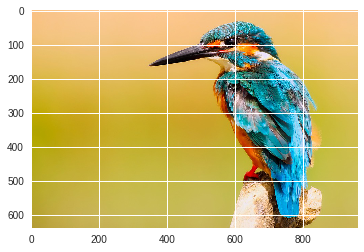

Variable containing:
 92
[torch.cuda.LongTensor of size 1 (GPU 0)]



In [140]:
image = image_loader('bird1.jpg')
plt.imshow(image)
plt.pause(0.001)
model.eval()
output = model(image_to_variable(image, cuda=use_gpu))
val, index = torch.max(output, 1)
print(index)

In [0]:
class CNNLayerVisualization():
    def __init__(self, model):
        self.model = model.cuda()
        self.model.eval()
        
        self.init_image()
  
    def init_image(self):
        self.created_image = np.uint8(np.full((224, 224, 3), 150))
        self.created_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        
    def visualize_filter(self, layer_index, filter_index):
        self.init_image()
        self.processed_image = preprocess_image(self.created_image)
        optimizer = SGD([self.processed_image], lr=6, weight_decay=1e-6)
        
        for i in range(50):
            optimizer.zero_grad()
            x = self.processed_image
            
            for index, layer in enumerate(self.model.features):
                x = layer(x.cuda())
                if index == layer_index:
                    break
            
            output = x[0, filter_index]
            loss = torch.mean(output)
            loss.backward()
            optimizer.step()
            self.created_image = recreate_image(self.processed_image.cpu())
            # self.processed_image = preprocess_image(self.created_image)
            
        return self.created_image

In [0]:
layer_vis = CNNLayerVisualization(model)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


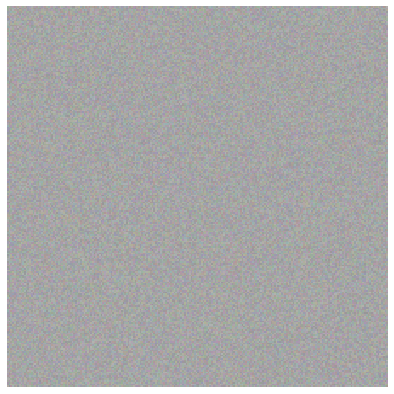

In [143]:
images = []
titles = []
gfig = plt.figure(figsize=(12, 7))
gif = plt.imshow(np.uint8(np.random.uniform(150, 180, (224, 224, 3))), animated=True)
gif.axes.get_xaxis().set_visible(False)
gif.axes.get_yaxis().set_visible(False)
gif_title = plt.axes().text(1.5, 2, '', transform = plt.axes().transAxes, horizontalalignment='center')


In [0]:
def plot_image(im, title = None):
    plt.figure(figsize=(20, 10))
    plt.imshow(im)
    plt.pause(0.001)
    
def plot_images(im, titles=None):
    plt.figure(figsize=(30, 20))
    
    for i in range(len(im)):
        plt.subplot(10 / 5 + 1, 5, i + 1)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(im[i])
        
    plt.pause(0.001)

def gif_init():
    global gfig
    gfig = plt.figure(figsize=(12, 7))
    git_title.set_text('')
    gif.set_data([0], [0])
    return gif, gif_title
    
def generate_gif(i):
    global images, titles, gif
    gif_title.set_text(titles[i])
    gif.set_array(images[i])
    return gif, gif_title

def show_animation():
    global gfig 
    return animation.FuncAnimation(gfig, generate_gif, init_func=gif_init, frames=10,interval=2000)

In [0]:
def show_layer(layer_num):
    images = []
    titles = []
    
    for i in range(10, 20):
        images.append(layer_vis.visualize_filter(layer_num, i))
        titles.append("Layer {} Filter {}".format(layer_num, i))
    
    plot_images(images, titles)
    return images, titles

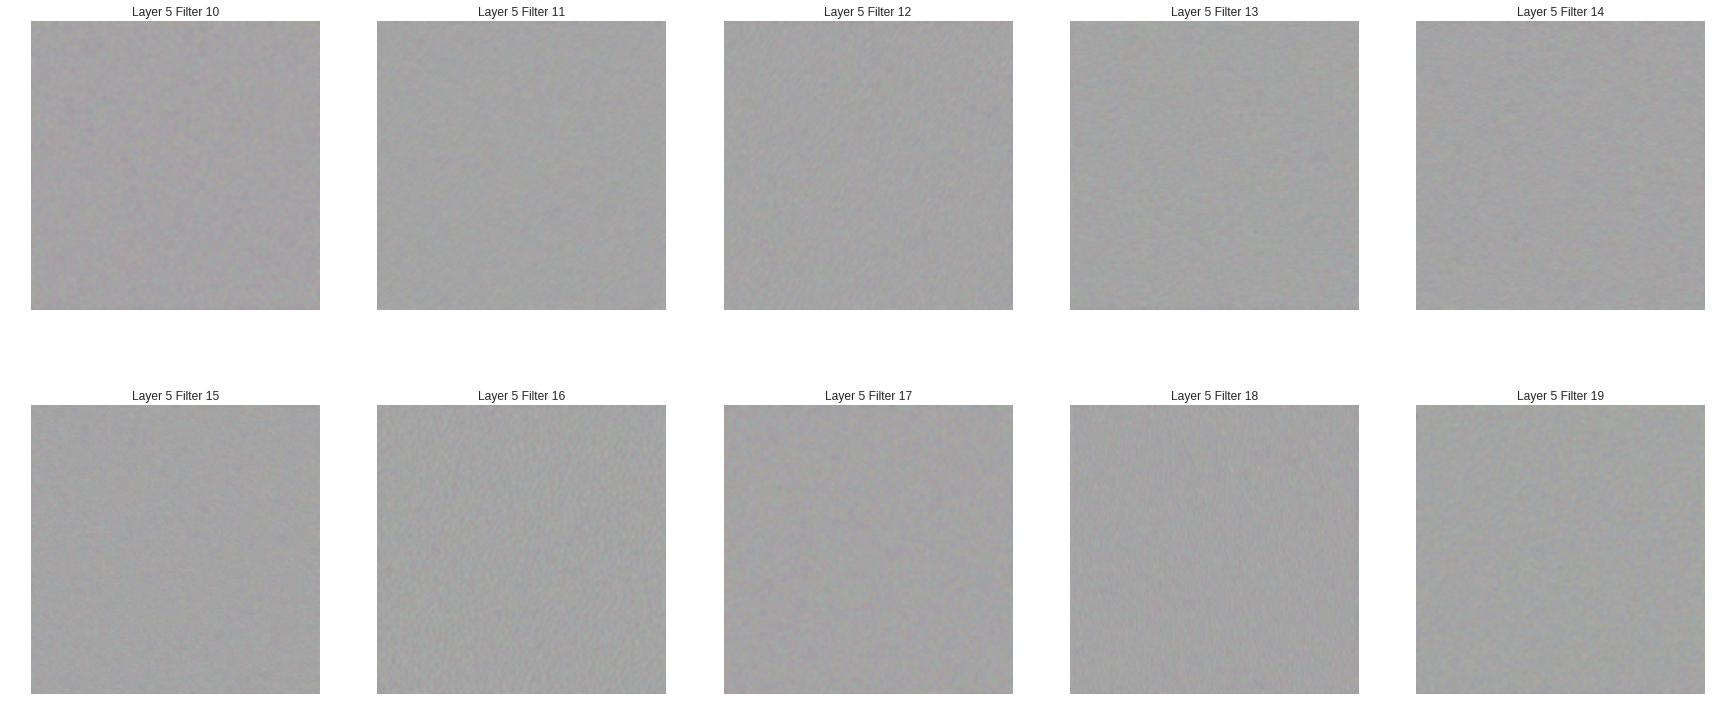

In [146]:
images, titles = show_layer(5)

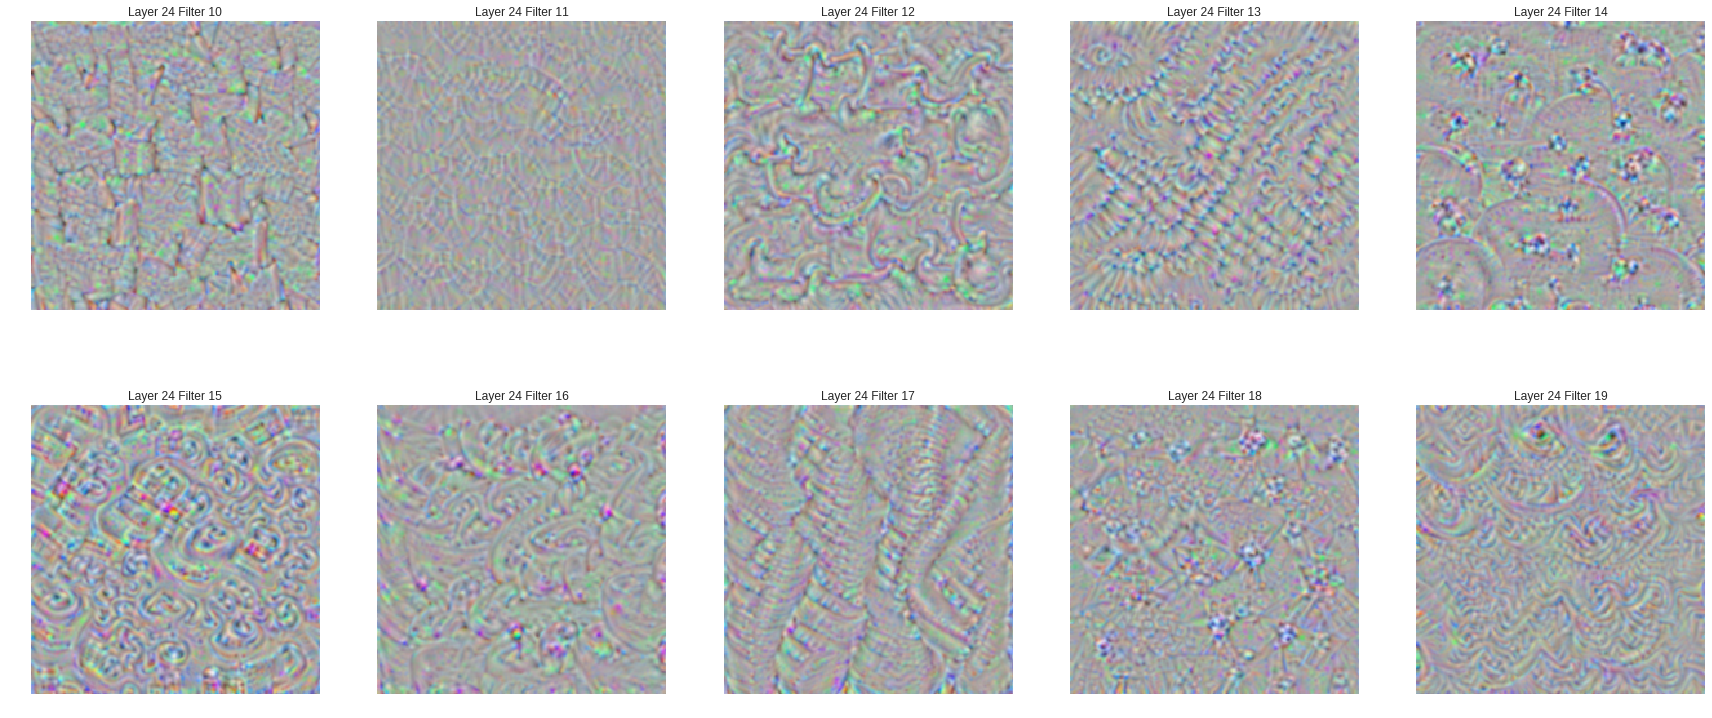

In [149]:
images, titles = show_layer(24)

In [0]:
show_animation()

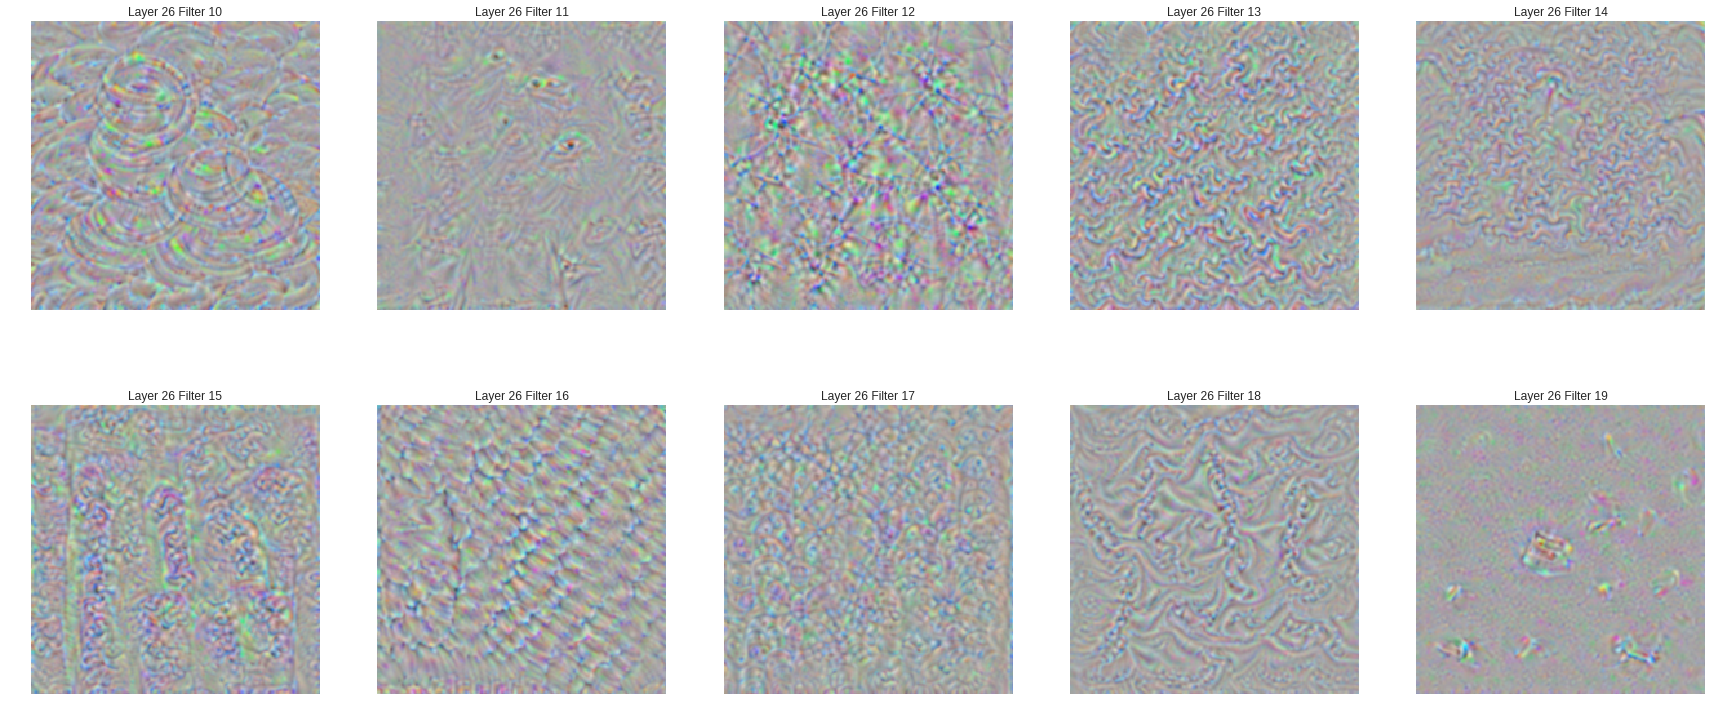

In [150]:
images, titles = show_layer(26)

In [0]:
show_animation()

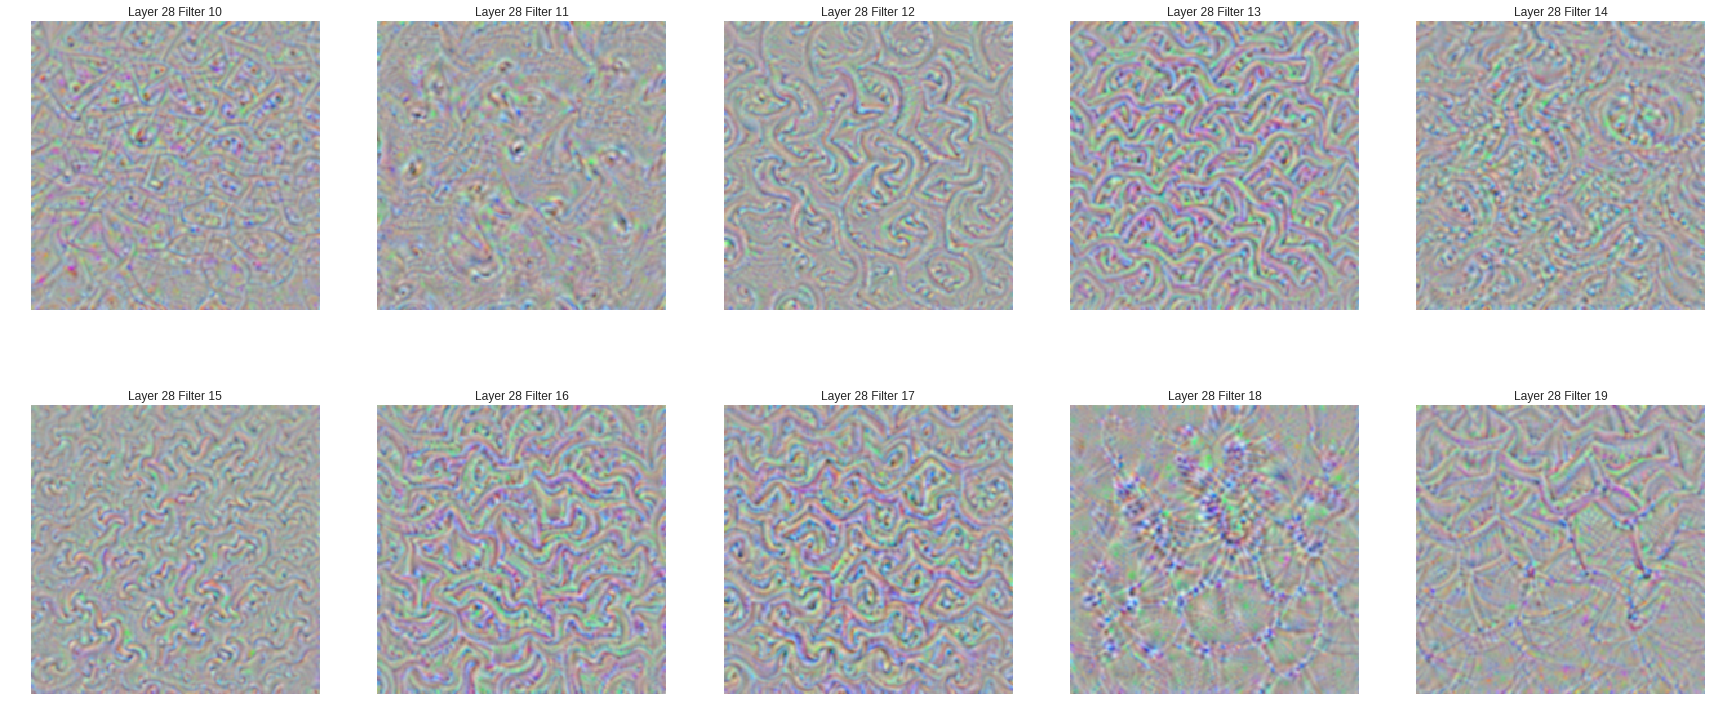

In [151]:
images, titles = show_layer(28)

In [0]:
show_animation()

## Deep Dream

In [0]:
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from io import BytesIO

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def showtensor(a):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    showarray(inp)
    clear_output(wait=True)
  

def objective(dst, guide_features):
    if guide_features is None:
      return dst.data
    else:
      x = dst.data[0].cpu().numpy()
      y = guide_features.data[0].cpu().numpy()
      ch, w, h = x.shape
      x = x.reshape(ch, -1)
      y = y.reshape(ch, -1)
      A = x.T.dot(y)
      diff = y[:, A.argmax(1)]
      diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])).cuda()
      return diff
  

def make_step(img, model, objective=objective, control=None, step_size=1.5, end=28, jitter=32, clip=True):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    
    img = np.roll(np.roll(img, ox, -1), oy, -2)
    tensor = torch.Tensor(img) 
    
    if use_gpu:
      img_var = Variable(tensor.cuda(), requires_grad=True)
    else:
      img_var = Variable(tensor, requires_grad=True)
    
    model.zero_grad()
      
    dst = img_var
    for index, layer in enumerate(model.features.children()):
      dst = layer(dst)
      if index == end:
        break
    
    delta = objective(dst, control)
    dst.backward(delta)
    
    ratio = torch.abs(img_var.grad.data).mean()
    img_var.data.add_(img_var.grad.data * step_size / ratio)
    
    result = img_var.data.cpu().numpy()
    result = np.roll(np.roll(result, -ox, -1), -oy, -2)
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    showtensor(result)
    
    return torch.Tensor(result)
                                                             
def deepdream(model, base_img, iter_n=10, octave_n=6, octave_scale=1.4, end=28, control=None, clip=True, objective=objective, **step_params):
  
    octaves = [base_img]
    
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
       
        src = octave_base + detail
       
        
        for i in range(iter_n):
            #print("Iter ", i)
            src = make_step(src, model, end=end, clip=clip, objective=objective, control=control, **step_params)

        detail = src.numpy() - octave_base

    return src
  

def make_step2(img, model, objective=objective, control=None, iter_n=10, step_size=1.5, end=28, jitter=32, clip=True):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    for i in range(iter_n):
        shift_x, shift_y = np.random.randint(-jitter, jitter + 1, 2)
        img = np.roll(np.roll(img, shift_x, -1), shift_y, -2)
        
        model.zero_grad()
        img_tensor = torch.Tensor(img)
        
        if use_gpu:
            img_variable = Variable(img_tensor.cuda(), requires_grad=True)
        else:
            img_variable = Variable(img_tensor, requires_grad=True)
        
        act_value = img_variable
        for index, layer in enumerate(model.features.children()):
          act_value = layer(act_value)
          
          if index == end:
            break
        diff_out = objective(act_value, control)
        act_value.backward(diff_out)
        
        ratio = np.abs(img_variable.grad.data.cpu().numpy()).mean()
        learning_rate_use = step_size / ratio
        img_variable.data.add_(img_variable.grad.data * learning_rate_use)
        
        img = img_variable.data.cpu().numpy()  # b, c, h, w
        img = np.roll(np.roll(img, -shift_x, -1), -shift_y, -2)
        img[0, :, :, :] = np.clip(img[0, :, :, :], -mean / std,
                                  (1 - mean) / std)
        
        showtensor(img)
    return img

                                                             
def deepdream2(model, base_img, iter_n=10, octave_n=6, octave_scale=1.4, end=28, control=None, clip=True, objective=objective, **step_params):
  
    octaves = [base_img]
    out = None
    
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
       
        src = octave_base + detail
        out = make_step2(src, model, end=end, clip=clip, objective=objective, control=control, iter_n=iter_n, **step_params)
        detail = out - octave_base

    #return out

(1024, 575)


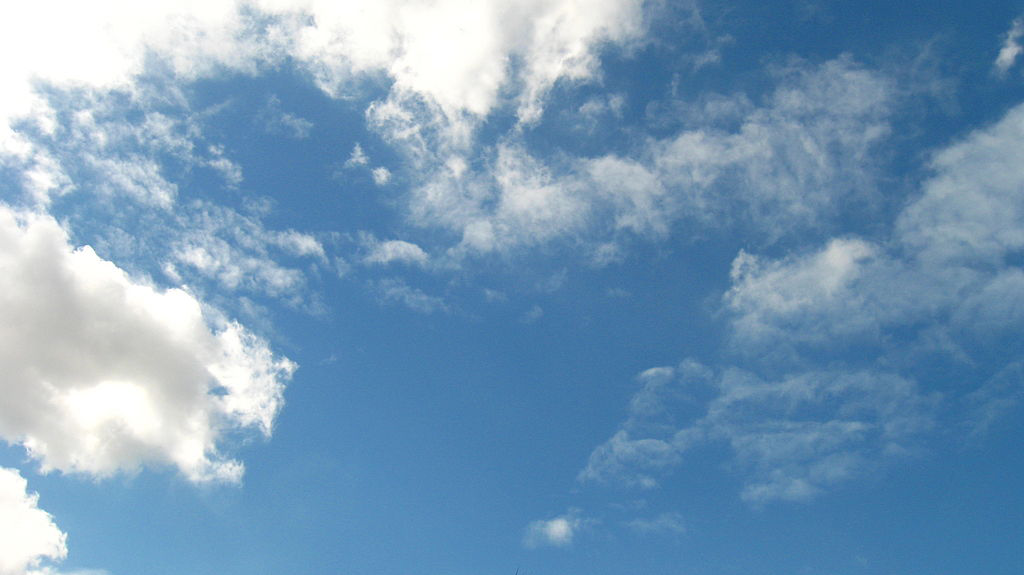

In [134]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# input_img = PIL.Image.fromarray(np.uint8(np.random.uniform(150, 180, (800, 800, 3)))) #
input_img = PIL.Image.open('sky.jpg')
input_tensor = img_transform(input_img).unsqueeze(0)
input_np = input_tensor.numpy()

print(input_img.size)
input_img

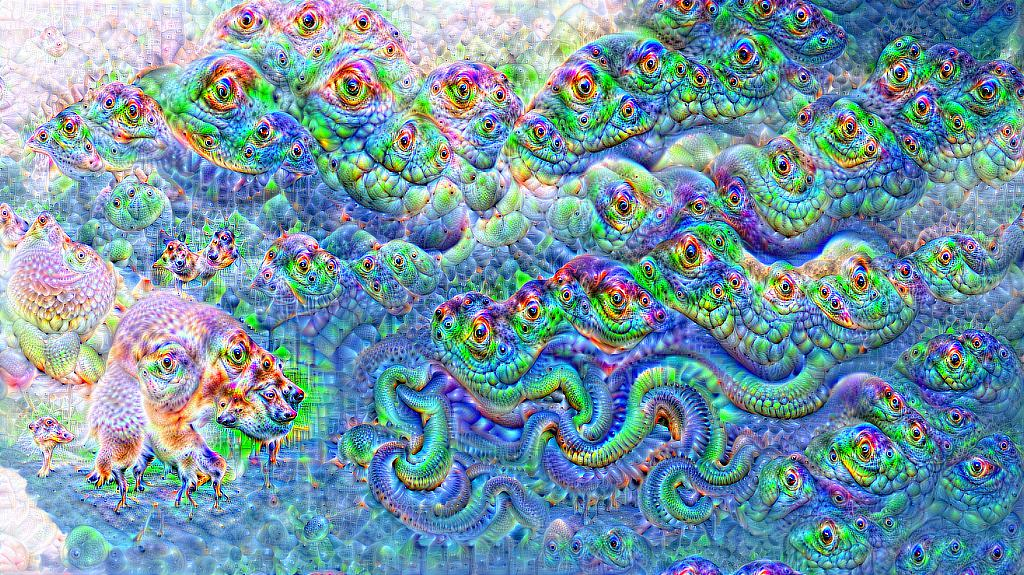

In [136]:
dream = deepdream(model, input_np, end=25, step_size=0.1, octave_n=6)

In [131]:
!wget "https://www.londonboatshow.com/-/media/Southampton/Images/sbs17/600x400/passenger_boat_600x400.ashx?la=en&hash=CAAA9AA14FE2CA20E5E8DBB94170E54B79F39120" -O boat.jpg

--2018-05-10 15:13:54--  https://www.londonboatshow.com/-/media/Southampton/Images/sbs17/600x400/passenger_boat_600x400.ashx?la=en&hash=CAAA9AA14FE2CA20E5E8DBB94170E54B79F39120
Resolving www.londonboatshow.com (www.londonboatshow.com)... 109.74.246.154
Connecting to www.londonboatshow.com (www.londonboatshow.com)|109.74.246.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51901 (51K) [image/jpeg]
Saving to: ‘boat.jpg’

boat.jpg            100%[===================>]  50.68K  --.-KB/s    in 0.1s    

2018-05-10 15:13:55 (353 KB/s) - ‘boat.jpg’ saved [51901/51901]



In [132]:
guide_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

guide_img = PIL.Image.open('boat.jpg')
guide = guide_transform(guide_img).unsqueeze(0)

plt.imshow(guide_img)

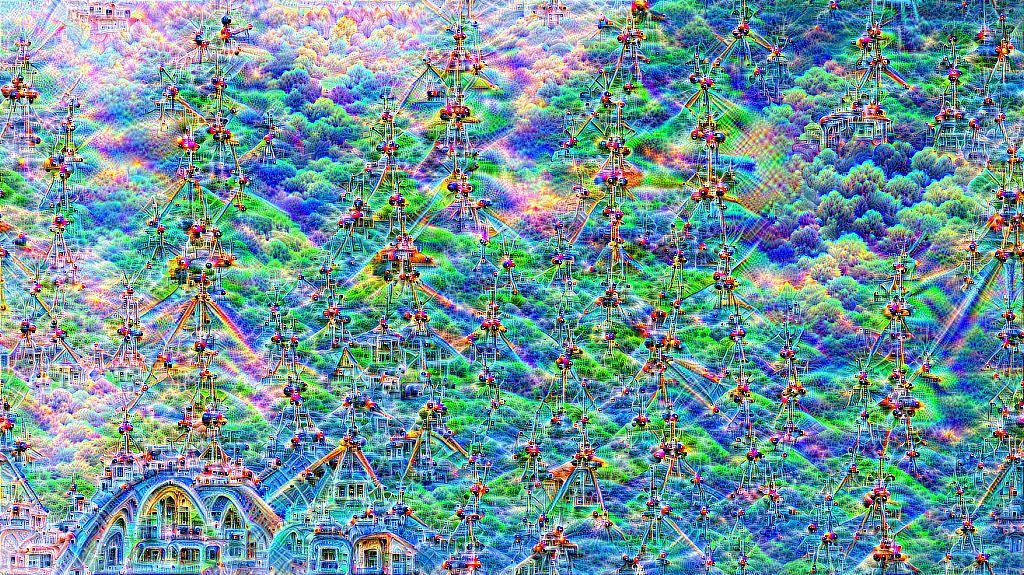

In [135]:
end = 25

if use_gpu:
  guide_features = Variable(guide.cuda())
else:
  guide_features = Variable(guide)

for index, layer in enumerate(model.features.children()):
  guide_features = layer(guide_features)
  if index == end:
    break
    
dream = deepdream(model, input_np, end=end, step_size=0.2, octave_n=6, control=guide_features)